In [1]:
%matplotlib inline

## [Gaussian Regression](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor)
- Requires a specified prior.
    - prior mean assumed to constant and zero (for ```normalize_y=False```) or the training data mean (```normalize_y=True```).
    - prior covariance specified with a kernel object.
- Kernel params are tweaked during fitting with the log-marginal-likelihood (LML) of the optimizer function.
- LMLs can have multiple local optima - optimizer can be restarted using ```n_restarts_optimizer```.

## Example: GPR to estimate data noise level

In [2]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

rng = np.random.RandomState(0)
X   = rng.uniform(0, 5, 20)[:, np.newaxis]
y   = 0.5 * np.sin(3 * X[:, 0]) + rng.normal(0, 0.5, X.shape[0])

#### First: high noise level, large length scale

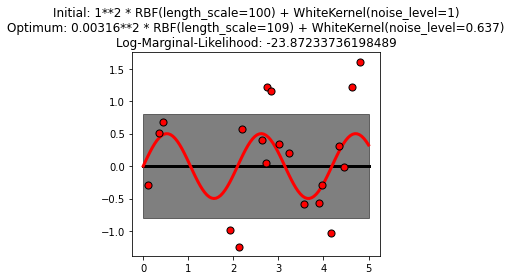

In [3]:
# First run
plt.figure()
kernel = 1.0 * RBF(length_scale=100.0, 
                   length_scale_bounds=(1e-2, 1e3))+ WhiteKernel(noise_level=1, 
                     noise_level_bounds=(1e-10, 1e+1))

gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X, y)
X_ = np.linspace(0, 5, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)

plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
plt.plot(X_, 0.5*np.sin(3*X_), 'r', lw=3, zorder=9)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

#### Second smaller noise level, shorter length scale

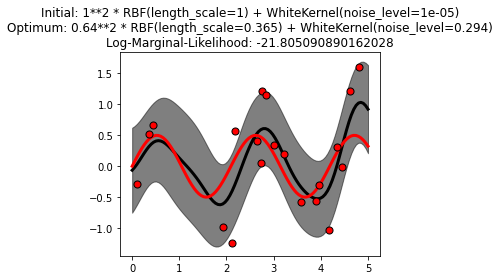

In [4]:
# Second run
plt.figure()
kernel = 1.0 * RBF(length_scale=1.0, 
                   length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X, y)

X_ = np.linspace(0, 5, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)

plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')

plt.plot(X_, 
         0.5*np.sin(3*X_), 
         'r', lw=3, zorder=9)

plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

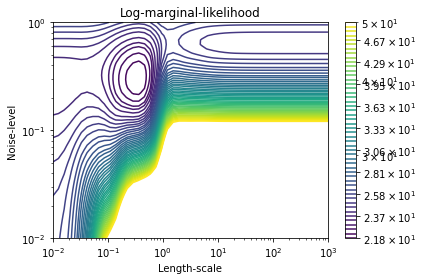

In [5]:
# Plot LML landscape
plt.figure()
theta0         = np.logspace(-2, 3, 49)
theta1         = np.logspace(-2, 0, 50)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = [[gp.log_marginal_likelihood(np.log([0.36, Theta0[i, j], Theta1[i, j]]))
        for i in range(Theta0.shape[0])] for j in range(Theta0.shape[1])]
LML = np.array(LML).T

vmin, vmax = (-LML).min(), (-LML).max()
vmax = 50
level = np.around(np.logspace(np.log10(vmin), 
                              np.log10(vmax), 50), 
                  decimals=1)

plt.contour(Theta0, Theta1, -LML,
            levels=level, norm=LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.tight_layout()
plt.show()

## GP Regression vs Kernel Ridge Regression
- Both techniques learn target functions via "the kernel trick".
- KRR learns a linear function in the induced space (corresponds to non-linear function in original space). It uses mean-squared error loss with ridge regularization.
- GPR uses kernel to define the covariance of a prior distribution over the target function & uses training data to define a likelihood.
- GPR can choose a kernel's params based on gradient-ascent.
- KRR has to use a grid-search (cross validated) mean-square loss function.

In [6]:
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

In [7]:
# Generate sample data
X = 15 * rng.rand(100, 1)
y = np.sin(X).ravel()
y += 3 * (0.5 - rng.rand(X.shape[0]))  # add noise

# Fit KernelRidge with parameter selection based on 5-fold cross validation
param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],
              "kernel": [ExpSineSquared(l, p)
                         for l in np.logspace(-2, 2, 10)
                         for p in np.logspace(0, 2, 10)]}

kr    = GridSearchCV(KernelRidge(), param_grid=param_grid)
stime = time.time()

kr.fit(X, y)
print("Time for KRR fitting: %.3f" % (time.time() - stime))

gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) \
    + WhiteKernel(1e-1)
gpr = GaussianProcessRegressor(kernel=gp_kernel)
stime = time.time()
gpr.fit(X, y)
print("Time for GPR fitting: %.3f" % (time.time() - stime))

# Predict using kernel ridge
X_plot = np.linspace(0, 20, 10000)[:, None]
stime  = time.time()
y_kr   = kr.predict(X_plot)
print("Time for KRR prediction: %.3f" % (time.time() - stime))

# Predict using gaussian process regressor
stime = time.time()
y_gpr = gpr.predict(X_plot, return_std=False)
print("Time for GPR prediction: %.3f" % (time.time() - stime))

stime = time.time()
y_gpr, y_std = gpr.predict(X_plot, return_std=True)
print("Time for GPR prediction with standard-deviation: %.3f"
      % (time.time() - stime))

Time for KRR fitting: 8.936
Time for GPR fitting: 0.192
Time for KRR prediction: 0.122
Time for GPR prediction: 0.115
Time for GPR prediction with standard-deviation: 0.143


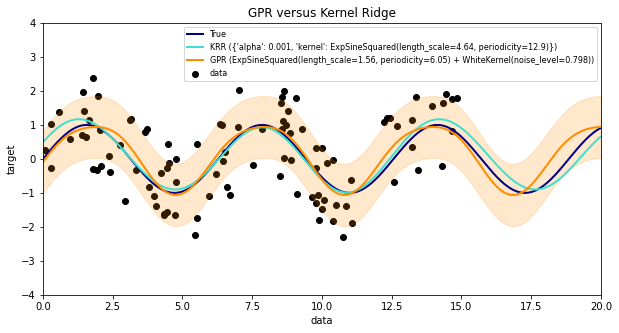

In [8]:
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data')
plt.plot(X_plot, np.sin(X_plot), color='navy', lw=lw, label='True')
plt.plot(X_plot, y_kr, color='turquoise', lw=lw,
         label='KRR (%s)' % kr.best_params_)
plt.plot(X_plot, y_gpr, color='darkorange', lw=lw,
         label='GPR (%s)' % gpr.kernel_)
plt.fill_between(X_plot[:, 0], y_gpr - y_std, y_gpr + y_std, color='darkorange',
                 alpha=0.2)
plt.xlabel('data')
plt.ylabel('target')
plt.xlim(0, 20)
plt.ylim(-4, 4)
plt.title('GPR versus Kernel Ridge')
plt.legend(loc="best",  scatterpoints=1, prop={'size': 8})
plt.show()

## Example: GPR: Moana Loa CO2 data
- example of kernel engineering & param optimization
- uses gradient ascent on LML metric
- goal: model CO2 concentration as function of time (t)

In [9]:
import numpy as np

from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

In [10]:
def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs

X,y = load_mauna_loa_atmospheric_co2()

In [11]:
# Kernel with parameters given in GPML book

# long-term trend
k1 = 66.0**2 * RBF(length_scale=67.0)
k2 =  2.4**2 * RBF(length_scale=90.0) * ExpSineSquared(
    length_scale=1.3, 
    periodicity=1.0)  # seasonal component

# medium term irregularity
k3 = 0.66**2 * RationalQuadratic(
    length_scale=1.2, 
    alpha=0.78)

# noise
k4 = 0.18**2 * RBF(length_scale=0.134) + WhiteKernel(
    noise_level=0.19**2)

kernel_gpml = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel_gpml, 
                              alpha=0,
                              optimizer=None, 
                              normalize_y=True)
gp.fit(X, y)

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

GPML kernel: 66**2 * RBF(length_scale=67) + 2.4**2 * RBF(length_scale=90) * ExpSineSquared(length_scale=1.3, periodicity=1) + 0.66**2 * RationalQuadratic(alpha=0.78, length_scale=1.2) + 0.18**2 * RBF(length_scale=0.134) + WhiteKernel(noise_level=0.0361)
Log-marginal-likelihood: 155.006


In [12]:
# Kernel with optimized parameters
# long term smooth rising trend
k1 = 50.0**2 * RBF(length_scale=50.0)   

k2 =  2.0**2 * RBF(length_scale=100.0) * ExpSineSquared(
    length_scale=1.0, 
    periodicity=1.0,
    periodicity_bounds="fixed")  # seasonal component

# medium term irregularities
k3 = 0.5**2 * RationalQuadratic(
    length_scale=1.0, 
    alpha=1.0)

k4 = 0.1**2*RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2,
    noise_level_bounds=(1e-3, np.inf))  # noise terms

kernel = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel, 
                              alpha=0,
                              normalize_y=True)
gp.fit(X, y)

print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))



Learned kernel: 2.59**2 * RBF(length_scale=51) + 0.257**2 * RBF(length_scale=137) * ExpSineSquared(length_scale=2.15, periodicity=1) + 0.118**2 * RationalQuadratic(alpha=2.32, length_scale=70.6) + 0.03**2 * RBF(length_scale=1.01) + WhiteKernel(noise_level=0.001)
Log-marginal-likelihood: 1161.609


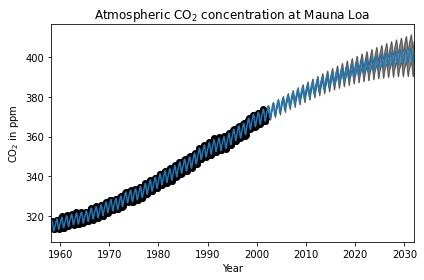

In [13]:
X_ = np.linspace(X.min(), X.max() + 30, 1000)[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)

# Illustration
plt.scatter(X, y, c='k')
plt.plot(X_, y_pred)
plt.fill_between(X_[:, 0], y_pred - y_std, y_pred + y_std,
                 alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.show()

## [Gaussian (Probabilistic) Classification](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html#sklearn.gaussian_process.GaussianProcessClassifier)
- Used when test predictions are class probabilities.
- Places a GP prior on a "nuisance function", whose values are not observed. (It is used to build the model, and is integrated out during prediction.)
- GPC uses a *logistic link* function (logit).
- GPC approximates a non-Gaussian posterior (non-Gaussian b/c that's not appropriate for classwise labeling) with a Gaussian based on a Laplace approximation.
- GPC supports multiclass classification via OvR or OvO training.

## Example: GPC performance vs. parameter choices

In [14]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, log_loss
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [15]:
train_size = 50
rng        = np.random.RandomState(0)
X          = rng.uniform(0, 5, 100)[:, np.newaxis]
y          = np.array(X[:, 0] > 2.5, dtype=int)


gp_fix = GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0), optimizer=None)
gp_opt = GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0))
                                   
gp_fix.fit(X[:train_size], y[:train_size])
gp_opt.fit(X[:train_size], y[:train_size])

print("Log Marginal Likelihood (initial): %.3f"
      % gp_fix.log_marginal_likelihood(gp_fix.kernel_.theta))

print("Log Marginal Likelihood (optimized): %.3f"
      % gp_opt.log_marginal_likelihood(gp_opt.kernel_.theta))

print("Accuracy: %.3f (initial) %.3f (optimized)"
      % (accuracy_score(y[:train_size], gp_fix.predict(X[:train_size])),
         accuracy_score(y[:train_size], gp_opt.predict(X[:train_size]))))

print("Log-loss: %.3f (initial) %.3f (optimized)"
      % (log_loss(y[:train_size], gp_fix.predict_proba(X[:train_size])[:, 1]),
         log_loss(y[:train_size], gp_opt.predict_proba(X[:train_size])[:, 1])))

Log Marginal Likelihood (initial): -17.598
Log Marginal Likelihood (optimized): -3.875
Accuracy: 1.000 (initial) 1.000 (optimized)
Log-loss: 0.214 (initial) 0.319 (optimized)


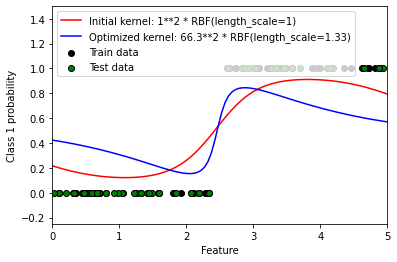

In [16]:
# Plot posteriors
plt.figure()
plt.scatter(X[:train_size, 0], y[:train_size], c='k', label="Train data",
            edgecolors=(0, 0, 0))
plt.scatter(X[train_size:, 0], y[train_size:], c='g', label="Test data",
            edgecolors=(0, 0, 0))
X_ = np.linspace(0, 5, 100)
plt.plot(X_, gp_fix.predict_proba(X_[:, np.newaxis])[:, 1], 'r',
         label="Initial kernel: %s" % gp_fix.kernel_)
plt.plot(X_, gp_opt.predict_proba(X_[:, np.newaxis])[:, 1], 'b',
         label="Optimized kernel: %s" % gp_opt.kernel_)
plt.xlabel("Feature")
plt.ylabel("Class 1 probability")
plt.xlim(0, 5)
plt.ylim(-0.25, 1.5)
plt.legend(loc="best")

#### Log-Marginal Likelihood for kernel's param choices

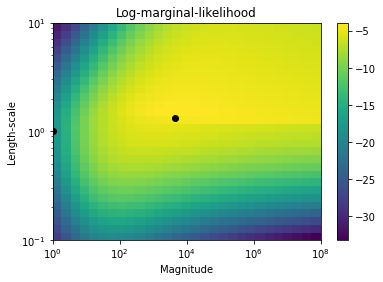

In [17]:
# Plot LML landscape
plt.figure()
theta0         = np.logspace(0, 8, 30)
theta1         = np.logspace(-1, 1, 29)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML            = [[gp_opt.log_marginal_likelihood(np.log([Theta0[i, j], 
                                                          Theta1[i, j]]))
                    for i in range(Theta0.shape[0])] 
                        for j in range(Theta0.shape[1])]

LML = np.array(LML).T

plt.plot(np.exp(gp_fix.kernel_.theta)[0], 
         np.exp(gp_fix.kernel_.theta)[1],
         'ko', zorder=10)

plt.plot(np.exp(gp_opt.kernel_.theta)[0], 
         np.exp(gp_opt.kernel_.theta)[1],
         'ko', zorder=10)

plt.pcolor(Theta0, Theta1, LML)
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
plt.xlabel("Magnitude")
plt.ylabel("Length-scale")
plt.title("Log-marginal-likelihood")
plt.show()

## Example: GPC, RBF vs Dot-Product kernels, XOR Data
- Dot-Product does considerably better b/c class boundaries are linear & coincide with coordinate axes (?)
- In practice, stationary kernels such as RBF should do better.

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct

In [19]:
xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
Y = np.logical_xor(X[:, 0] > 0, 
                   X[:, 1] > 0)

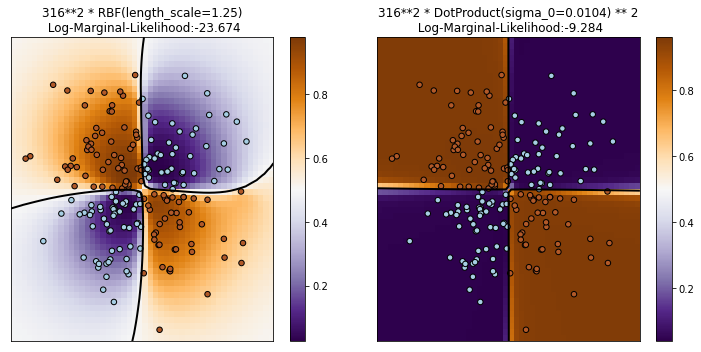

In [20]:
# fit the model

plt.figure(figsize=(10, 5))

kernels = [1.0 * RBF(length_scale=1.0), 
           1.0 * DotProduct(sigma_0=1.0)**2]

for i, kernel in enumerate(kernels):
    clf = GaussianProcessClassifier(kernel=kernel, 
                                    warm_start=True).fit(X, Y)

    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    plt.subplot(1, 2, i + 1)
    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    contours = plt.contour(xx, yy, Z, levels=[0.5], linewidths=2,
                           colors=['k'])
    
    plt.scatter(X[:, 0], 
                X[:, 1], s=30, c=Y, 
                cmap=plt.cm.Paired,
                edgecolors=(0, 0, 0))

    plt.xticks(())
    plt.yticks(())
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title("%s\n Log-Marginal-Likelihood:%.3f"
              % (clf.kernel_, clf.log_marginal_likelihood(clf.kernel_.theta)),
              fontsize=12)

plt.tight_layout()
plt.show()

## Example: GPC, non-binary classification, isotropic vs anisotropic RBF kernels
- anisotropic RBF does slightly better by assigning different length scales to the two feature dimensions.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [22]:
iris = datasets.load_iris()
X    = iris.data[:, :2]  # we only take the first two features.
y    = np.array(iris.target, dtype=int)
h    = .02  # step size

kernel  = 1.0 * RBF([1.0])
kernel2 = 1.0 * RBF([1.0, 1.0])

gpc_rbf_isotropic   = GaussianProcessClassifier(kernel=kernel).fit(X, y)
gpc_rbf_anisotropic = GaussianProcessClassifier(kernel=kernel2).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

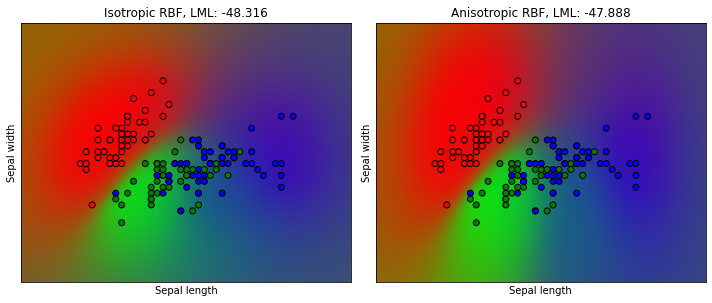

In [23]:
titles = ["Isotropic RBF", "Anisotropic RBF"]
plt.figure(figsize=(10, 5))
for i, clf in enumerate((gpc_rbf_isotropic, 
                         gpc_rbf_anisotropic)):

    # Plot predicted probabilities. Assign color to each mesh point.
    plt.subplot(1, 2, i + 1)

    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape((xx.shape[0], xx.shape[1], 3))
    
    plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

    # Plot also the training points
    plt.scatter(X[:, 0], 
                X[:, 1], 
                c=np.array(["r", "g", "b"])[y],
                edgecolors=(0, 0, 0))
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title("%s, LML: %.3f" %
              (titles[i], clf.log_marginal_likelihood(clf.kernel_.theta)))

plt.tight_layout()
plt.show()

## [Gaussian Process Kernels](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Kernel.html#sklearn.gaussian_process.kernels.Kernel), aka Covariance Functions
- Determines shape of a GP's prior & posterior.
- Encodes the function's assumptions by defining the "similarity" of two datapoints, assuming they should have similar values.
- Kernels come in two categories:
    - *"stationary"*: Only depends on the distances of the datapoints (they don't care about input values). Stationary kernels also can be divided into *isotropic* (invariant to input space rotations) and *anisotropic* kernels. 
    - *"non-stationary"*: Also depends on datapoint values.
- Scikit kernels can find the "auto-covariance" between all pairs of datapoints in a 2D array, or the "cross-covariance" between two 2D arrays.
- Kernels are represented by a vector of params, for example length-scales or periodicity, that must be created with initial (```theta```) and boundary (```bounds```) values.

In [24]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
kernel = ConstantKernel(
    constant_value=1.0, 
    constant_value_bounds=(0.0, 10.0)) * RBF(length_scale=0.5, 
                                             length_scale_bounds=(0.0, 10.0)) + RBF(length_scale=2.0, length_scale_bounds=(0.0, 10.0))

for hyperparameter in kernel.hyperparameters: print(hyperparameter)

params = kernel.get_params()

for key in sorted(params): print("%s : %s" % (key, params[key]))

print(kernel.theta)  # Note: log-transformed
print(kernel.bounds)  # Note: log-transformed

Hyperparameter(name='k1__k1__constant_value', value_type='numeric', bounds=array([[ 0., 10.]]), n_elements=1, fixed=False)
Hyperparameter(name='k1__k2__length_scale', value_type='numeric', bounds=array([[ 0., 10.]]), n_elements=1, fixed=False)
Hyperparameter(name='k2__length_scale', value_type='numeric', bounds=array([[ 0., 10.]]), n_elements=1, fixed=False)
k1 : 1**2 * RBF(length_scale=0.5)
k1__k1 : 1**2
k1__k1__constant_value : 1.0
k1__k1__constant_value_bounds : (0.0, 10.0)
k1__k2 : RBF(length_scale=0.5)
k1__k2__length_scale : 0.5
k1__k2__length_scale_bounds : (0.0, 10.0)
k2 : RBF(length_scale=2)
k2__length_scale : 2.0
k2__length_scale_bounds : (0.0, 10.0)
[ 0.         -0.69314718  0.69314718]
[[      -inf 2.30258509]
 [      -inf 2.30258509]
 [      -inf 2.30258509]]


/home/bjpcjp/.local/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:301: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


## Std Kernels in scikit-learn

- [Constant](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ConstantKernel.html#sklearn.gaussian_process.kernels.ConstantKernel)
- [Productl](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Product.html#sklearn.gaussian_process.kernels.Product)
- [Sum](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Sum.html#sklearn.gaussian_process.kernels.Sum)
- [White Kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.WhiteKernel.html#sklearn.gaussian_process.kernels.WhiteKernel) - explains the noise level of a signal. Defined as $k(x_i, x_j) = noise\_level \text{ if } x_i == x_j \text{ else } 0$
- [Exponentiation](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Exponentiation.html#sklearn.gaussian_process.kernels.Exponentiation)- combines a base kernel with scalar parameter: $k_{exp}(X, Y) = k(X, Y)^p$

#### [Radial Basis Function (RBF)](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html#sklearn.gaussian_process.kernels.RBF) - stationary, aka "squared exponential".
- defined as $k(x_i, x_j) = \text{exp}\left(- \frac{d(x_i, x_j)^2}{2l^2} \right)$

In [25]:
import numpy as np

from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, 
                                              Matern, 
                                              RationalQuadratic,
                                              ExpSineSquared, 
                                              DotProduct,
                                              ConstantKernel)

In [26]:
kernels = [
    1.0 * RBF(length_scale=1.0, 
              length_scale_bounds=(1e-1, 10.0)),
    1.0 * RationalQuadratic(length_scale=1.0, 
                            alpha=0.1),
    1.0 * ExpSineSquared(length_scale=1.0, 
                         periodicity=3.0,
                         length_scale_bounds=(0.1, 10.0),
                         periodicity_bounds=(1.0, 10.0)),
    ConstantKernel(0.1, (0.01, 10.0))
                   * (DotProduct(sigma_0=1.0, 
                                 sigma_0_bounds=(0.1, 10.0)) ** 2),
    1.0 * Matern(length_scale=1.0, 
                 length_scale_bounds=(1e-1, 10.0),
                 nu=1.5)
]

/home/bjpcjp/.local/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


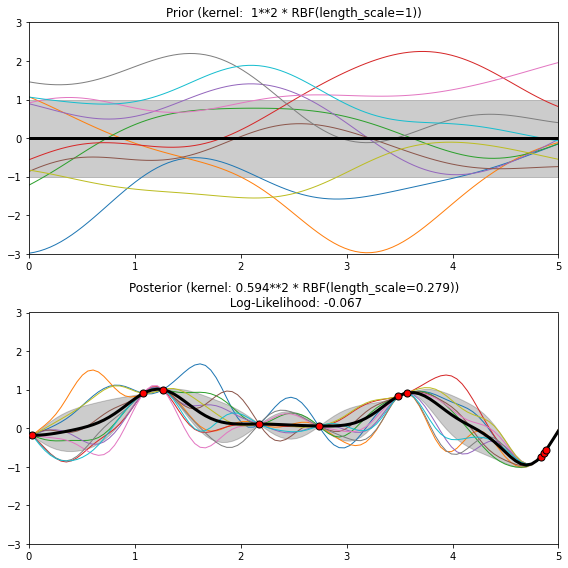

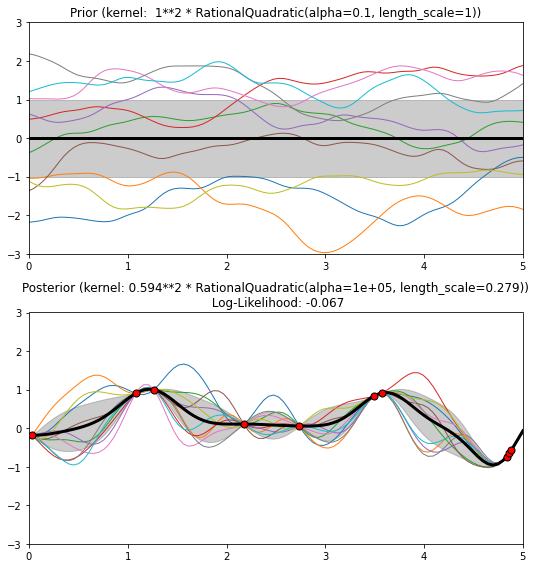

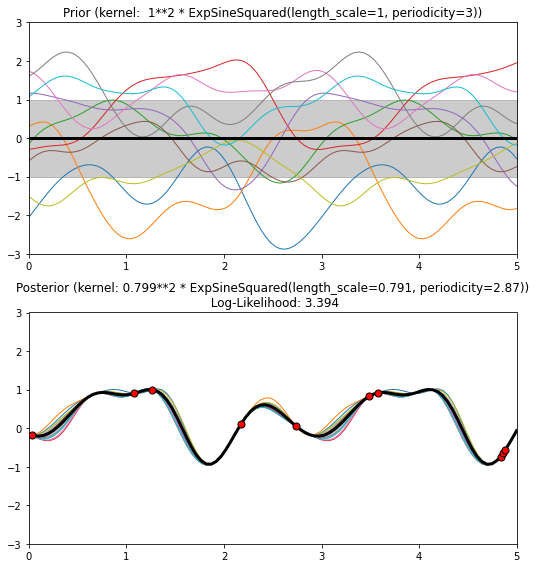

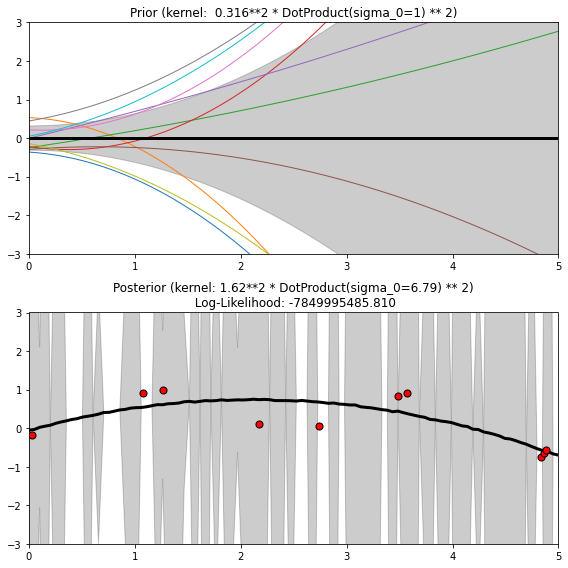

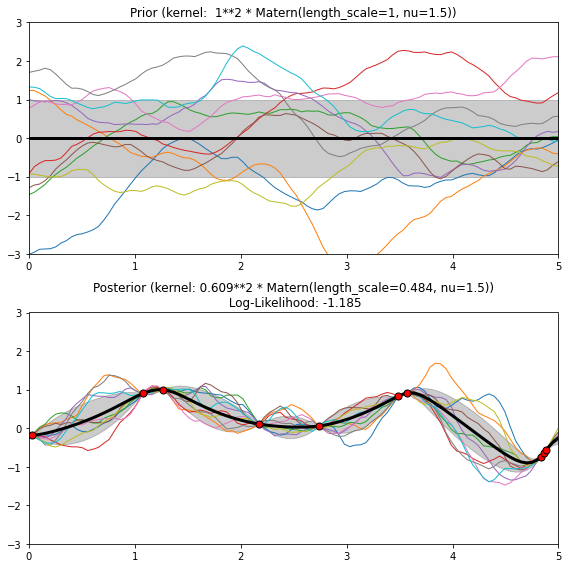

In [27]:
for kernel in kernels:
    # Specify Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel)

    # Plot prior
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')
    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Prior (kernel:  %s)" % kernel, fontsize=12)

    # Generate data and fit GP
    rng = np.random.RandomState(4)
    X = rng.uniform(0, 5, 10)[:, np.newaxis]
    y = np.sin((X[:, 0] - 2.5) ** 2)
    gp.fit(X, y)

    # Plot posterior
    plt.subplot(2, 1, 2)
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')

    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Posterior (kernel: %s)\n Log-Likelihood: %.3f"
              % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta)),
              fontsize=12)
    plt.tight_layout()

plt.show()

#### [Matern kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Matern.html#sklearn.gaussian_process.kernels.Matern)
- Generalization of an RBF kernel; additional param _v_ controls the smoothness of the resulting function.
- Defined as $k(x_i, x_j) = \frac{1}{\Gamma(\nu)2^{\nu-1}}\Bigg(\frac{\sqrt{2\nu}}{l} d(x_i , x_j )\Bigg)^\nu K_\nu\Bigg(\frac{\sqrt{2\nu}}{l} d(x_i , x_j )\Bigg),$

- $d(\cdot,\cdot)$ = Euclidean distance
- $K_\nu(\cdot)$ = modified Bessel function
- $\Gamma(\cdot)$ = gamma function
- Converges towards an RBF kernel as _v_ approaches infinity.

#### [Rational Quadratic kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RationalQuadratic.html#sklearn.gaussian_process.kernels.RationalQuadratic)
- Can be thought of as an infinite sum of RBF kernels with varying length scales.
- Defined as $k(x_i, x_j) = \left(1 + \frac{d(x_i, x_j)^2}{2\alpha l^2}\right)^{-\alpha}$

#### [Exp-Sine-Squared kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ExpSineSquared.html#sklearn.gaussian_process.kernels.ExpSineSquared)
- Good for modeling periodic functions. 
- Defined as $k(x_i, x_j) = \text{exp}\left(- \frac{ 2\sin^2(\pi d(x_i, x_j) / p) }{ l^ 2} \right)$

#### [Dot-Product kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.DotProduct.html#sklearn.gaussian_process.kernels.DotProduct)
- Commonly combined with exponentiation, esp exponent = 2.
- Defined as $k(x_i, x_j) = \sigma_0 ^ 2 + x_i \cdot x_j$